In [761]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 설정
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

In [762]:
# !pip install lightgbm

- ★(8) ARI_CO	도착항의 소속국가(도착항 앞 2글자)
- ★(10) ARI_PO	도착항의 항구명(도착항 뒤 글자)
- (14) SHIP_TYPE_CATEGORY	선종 통합 바탕으로 5대 선종으로 분류
- ★(1) DIST	정박지(ber_port)와 접안지 사이의 거리
- ATA	anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)
    - ★(3) month ATA를 년/월/일/시간 등으로 분리한 것
    - ★(6) year
    - ★(9) day
    - hour
- ID	선박식별 일련번호
- BREADTH	선박의 폭
- BUILT	선박의 연령
- ★(5) DEADWEIGHT	선박의 재화중량톤수
- DEPTH	선박의 깊이
- DRAUGHT	흘수 높이
- ★(11) GT	용적톤수(Gross Tonnage)값
- (12) LENGTH	선박의 길이
- (16) SHIPMANAGER	선박 소유주
- (15) FLAG	선박의 국적
- U_WIND	풍향 u벡터
- V_WIND	풍향 v벡터
- (17) AIR_TEMPERATURE	기온
- BN	보퍼트 풍력 계급
- ATA_LT	anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)
- ★(2) PORT_SIZE	접안지 폴리곤 영역의 크기
- CI_HOUR	대기시간 (Target)

In [763]:
import pandas as pd
ship_df = pd.read_csv(r'D:\현대공모전\train.csv').drop(columns=['SAMPLE_ID'])
ship_test = pd.read_csv(r'D:\현대공모전\test.csv').drop(columns=['SAMPLE_ID'])

In [862]:
df = ship_df.copy()
test = ship_test.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              228251 non-nul

In [863]:
len(df)

391939

In [864]:
# datetime 컬럼 처리
df['ATA'] = pd.to_datetime(df['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for idf in [df, test]:
    idf['year'] = idf['ATA'].dt.year
    idf['month'] = idf['ATA'].dt.month
    idf['day'] = idf['ATA'].dt.day
    idf['hour'] = idf['ATA'].dt.hour
    idf['minute'] = idf['ATA'].dt.minute
    idf['weekday'] = idf['ATA'].dt.weekday
    idf.drop('ATA', axis=1, inplace=True)

In [865]:
df.head(3)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
0,SG,GIW5,Container,30.881018,Z618338,30.0,24,24300,10.0,10.0,...,NaN,5,0.002615,3.45,2018,12,17,21,29,0
1,IN,UJM2,Bulk,0.000000,X886125,30.0,13,35900,10.0,10.0,...,NaN,12,0.000217,0.00,2014,9,23,6,59,1
2,CN,EUC8,Container,0.000000,T674582,50.0,12,146000,30.0,20.0,...,NaN,6,0.001614,0.00,2015,2,3,22,0,1


In [866]:
# 초기 결측값
print(f'전체 개수: {len(df)}')
df.isnull().sum()[df.isnull().sum()>0]

# 선박의 폭, 선박 깊이, 홀수 높이, 선박 길이 -> 23856번 행 1줄
# 풍향 u벡터, 풍향 v벡터 -> 둘이 동시에 없음
# 기온, 보퍼트 풍력 계급 -> 보퍼트 풍력계급이 null인 것은 기온도 null값임

전체 개수: 391939


BREADTH                 1
DEPTH                   1
DRAUGHT                 1
LENGTH                  1
U_WIND             163688
V_WIND             163688
AIR_TEMPERATURE    164630
BN                 163688
dtype: int64

In [867]:
# 선박의 폭, 선박 깊이, 홀수 높이, 선박 길이
# 동일 선종, 용적톤수 +-50인 값들의 최빈값으로 대체
idx = df['BREADTH'].isnull() | df['DEPTH'].isnull() | df['DRAUGHT'].isnull() | df['LENGTH'].isnull()
ship_null_df = df[df['SHIP_TYPE_CATEGORY']==df[idx]['SHIP_TYPE_CATEGORY'].values[0]]
ship_null_df = ship_null_df[(ship_null_df.GT>=df.loc[idx, 'GT'].values[0]) & (ship_null_df.GT<=df.loc[idx, 'GT'].values[0])]

for i in ['BREADTH','DEPTH', 'DRAUGHT', 'LENGTH']:
    df.loc[idx, i] = ship_null_df[i].mode().values[0]

df[idx][['SHIP_TYPE_CATEGORY','BREADTH','DEPTH', 'DRAUGHT', 'LENGTH', 'GT']]

,SHIP_TYPE_CATEGORY,BREADTH,DEPTH,DRAUGHT,LENGTH,GT
356484,Cargo,10.0,10.0,0.0,70.0,500


In [868]:
# 시간대 범주화
def get_hour(hour):
    cat = ''
    if hour < 6: cat='0-6'
    elif hour < 12: cat= '6-12'
    elif hour < 18: cat= '12-18'
    else: cat = '18-24'
    return cat

df['hour_cat'] = df.hour.apply(lambda x: get_hour(x))
df['hour_lt_cat'] = df.ATA_LT.apply(lambda x: get_hour(x))

test['hour_cat'] = test.hour.apply(lambda x: get_hour(x))
test['hour_lt_cat'] = test.ATA_LT.apply(lambda x: get_hour(x))

In [869]:
# 풍향 u벡터, 풍향 v벡터, 기온, 보퍼트 풍향 계급: null 값 처리 (4단계 필터링)
for idf in [df,test]:
    for i in ['U_WIND','V_WIND','BN', 'AIR_TEMPERATURE']:
        idf[i].fillna(df.groupby(['ARI_PO', 'month', 'hour_cat'])[i].transform('mean'), inplace=True)   #지역별/월별/시간대별
        idf[i].fillna(df.groupby(['ARI_PO', 'month', 'day'])[i].transform('mean'), inplace=True)   #지역별/월별/날짜별
        idf[i].fillna(df.groupby(['ARI_PO', 'month'])[i].transform('mean'), inplace=True)   #지역별/월별
        idf[i].fillna(df.groupby(['ARI_PO'])[i].transform('mean'), inplace=True)   #지역별
    
# 이러고도 남은 건 국가 평균으로 대체
for idf in [df,test]:
    for i in ['U_WIND','V_WIND','BN', 'AIR_TEMPERATURE']:
        idf[i].fillna(df.groupby(['ARI_CO'])[i].transform('mean'), inplace=True)
    
# 결과
print(df[['U_WIND','V_WIND','BN','AIR_TEMPERATURE']].isnull().sum(), '\n')
print(test[['U_WIND','V_WIND','BN','AIR_TEMPERATURE']].isnull().sum())

U_WIND             0
V_WIND             0
BN                 0
AIR_TEMPERATURE    0
dtype: int64 

U_WIND             0
V_WIND             0
BN                 0
AIR_TEMPERATURE    0
dtype: int64


#### **시간대 범주화**
- 최종 4개로 구분하기로 결정(0-6, 6-12, 12-18, 18-24)

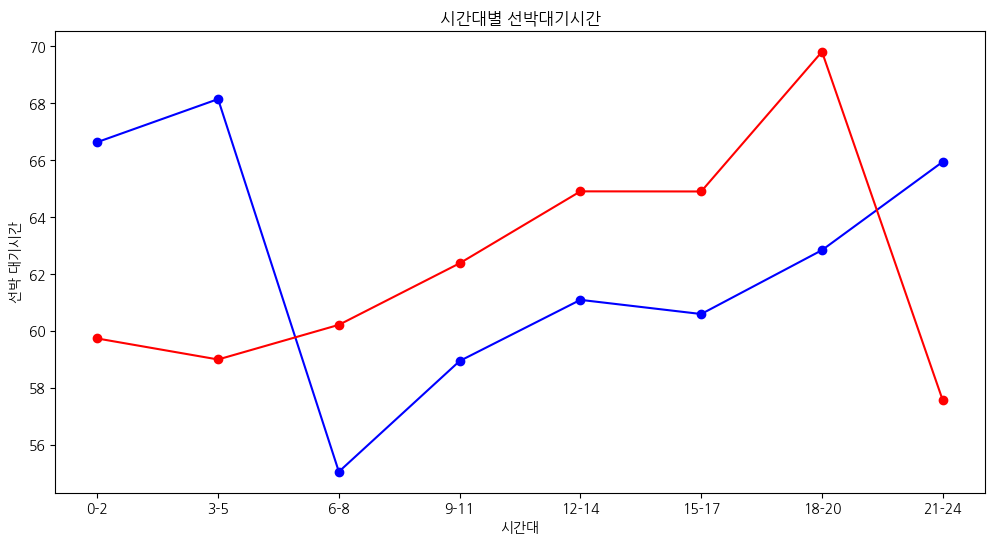

In [870]:
# 시간대 범주화(3시간 단위로)
def get_hour(hour):
    cat = ''
    if hour < 3: cat='0-2'
    elif hour < 6: cat= '3-5'
    elif hour < 9: cat= '6-8'
    elif hour < 12: cat='9-11'
    elif hour < 15: cat='12-14'
    elif hour < 18: cat='15-17'
    elif hour < 21: cat='18-20'
    else: cat = '21-24'
    return cat

df['hour_cat'] = df.hour.apply(lambda x: get_hour(x))
df['hour_lt_cat'] = df.ATA_LT.apply(lambda x: get_hour(x))

test['hour_cat'] = test.hour.apply(lambda x: get_hour(x))
test['hour_lt_cat'] = test.ATA_LT.apply(lambda x: get_hour(x))

# 시간대별 선박대기시간
day_hour_data = df.groupby('hour_lt_cat')['CI_HOUR'].mean()
day_hour_data2 = df.groupby('hour_cat')['CI_HOUR'].mean()
sorted_labels3 = ['0-2','3-5','6-8','9-11','12-14','15-17','18-20','21-24']
day_hour_data = day_hour_data.reindex(sorted_labels3)
day_hour_data2 = day_hour_data2.reindex(sorted_labels3)

plt.figure(figsize=(12, 6))
plt.plot(day_hour_data.index, day_hour_data.values, marker='o', linestyle='-', color='b')
plt.plot(day_hour_data2.index, day_hour_data2.values, marker='o', linestyle='-', color='r')
plt.xlabel('시간대'); plt.ylabel('선박 대기시간')
plt.title('시간대별 선박대기시간')
plt.show()   #빨(현지시간), 파(세계시간)

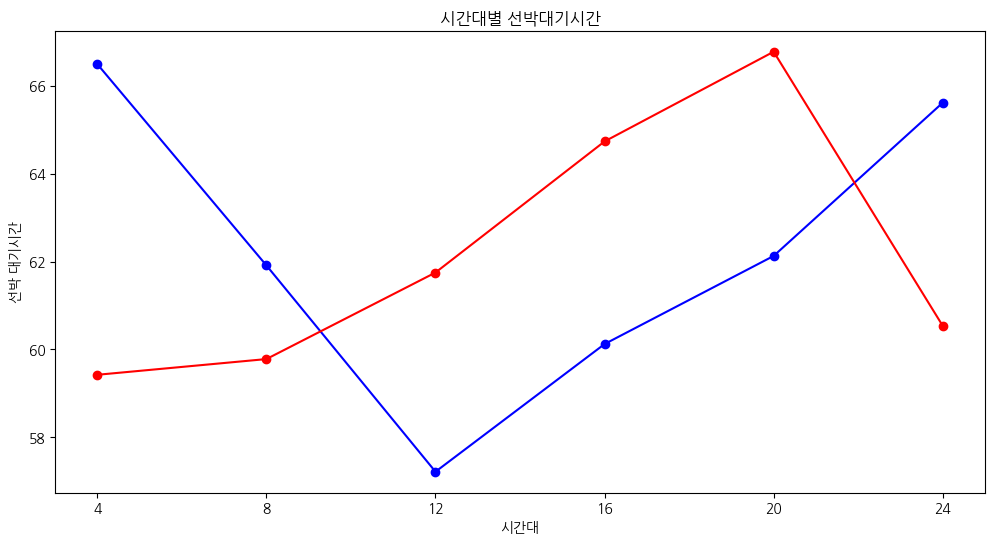

In [871]:
# 시간대 범주화(3시간 단위로)
def get_hour(hour):
    cat = ''
    if hour < 4: cat='4'
    elif hour < 8: cat= '8'
    elif hour < 12: cat= '12'
    elif hour < 16: cat= '16'
    elif hour < 20: cat= '20'
    else: cat = '24'
    return cat

df['hour_cat'] = df.hour.apply(lambda x: get_hour(x))
df['hour_lt_cat'] = df.ATA_LT.apply(lambda x: get_hour(x))

test['hour_cat'] = test.hour.apply(lambda x: get_hour(x))
test['hour_lt_cat'] = test.ATA_LT.apply(lambda x: get_hour(x))

# 시간대별 선박대기시간
day_hour_data = df.groupby('hour_lt_cat')['CI_HOUR'].mean()
day_hour_data2 = df.groupby('hour_cat')['CI_HOUR'].mean()
sorted_labels3 = ['4','8','12','16','20','24']
day_hour_data = day_hour_data.reindex(sorted_labels3)
day_hour_data2 = day_hour_data2.reindex(sorted_labels3)

plt.figure(figsize=(12, 6))
plt.plot(day_hour_data.index, day_hour_data.values, marker='o', linestyle='-', color='b')
plt.plot(day_hour_data2.index, day_hour_data2.values, marker='o', linestyle='-', color='r')
plt.xlabel('시간대'); plt.ylabel('선박 대기시간')
plt.title('시간대별 선박대기시간')
plt.show()   #빨(현지시간), 파(세계시간)

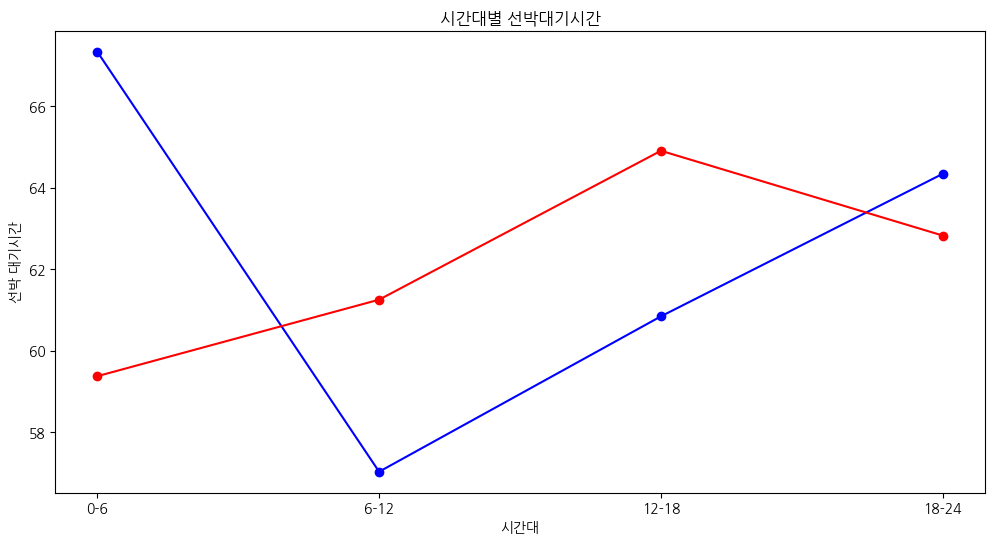

In [872]:
# 시간대 범주화(3시간 단위로)
def get_hour(hour):
    cat = ''
    if hour < 6: cat='0-6'
    elif hour < 12: cat= '6-12'
    elif hour < 18: cat= '12-18'
    else: cat = '18-24'
    return cat

df['hour_cat'] = df.hour.apply(lambda x: get_hour(x))
df['hour_lt_cat'] = df.ATA_LT.apply(lambda x: get_hour(x))

test['hour_cat'] = test.hour.apply(lambda x: get_hour(x))
test['hour_lt_cat'] = test.ATA_LT.apply(lambda x: get_hour(x))

# 시간대별 선박대기시간
day_hour_data = df.groupby('hour_lt_cat')['CI_HOUR'].mean()
day_hour_data2 = df.groupby('hour_cat')['CI_HOUR'].mean()

sorted_labels3 = ['0-6','6-12','12-18','18-24']
day_hour_data = day_hour_data.reindex(sorted_labels3)
day_hour_data2 = day_hour_data2.reindex(sorted_labels3)

plt.figure(figsize=(12, 6))
plt.plot(day_hour_data.index, day_hour_data.values, marker='o', linestyle='-', color='b')
plt.plot(day_hour_data2.index, day_hour_data2.values, marker='o', linestyle='-', color='r')
plt.xlabel('시간대'); plt.ylabel('선박 대기시간')
plt.title('시간대별 선박대기시간')
plt.show()   #빨(현지시간), 파(세계시간)

#### **항구-시간대별 대기시간**
- 각 항구별로 시간대별 차이가 존재, 다만 그래프 스케일이 커서 차이가 명확히 보이지x
- 일부 항구는 건수가 적어, 시간대별 평균을 보기에 적합하지 않기도 함

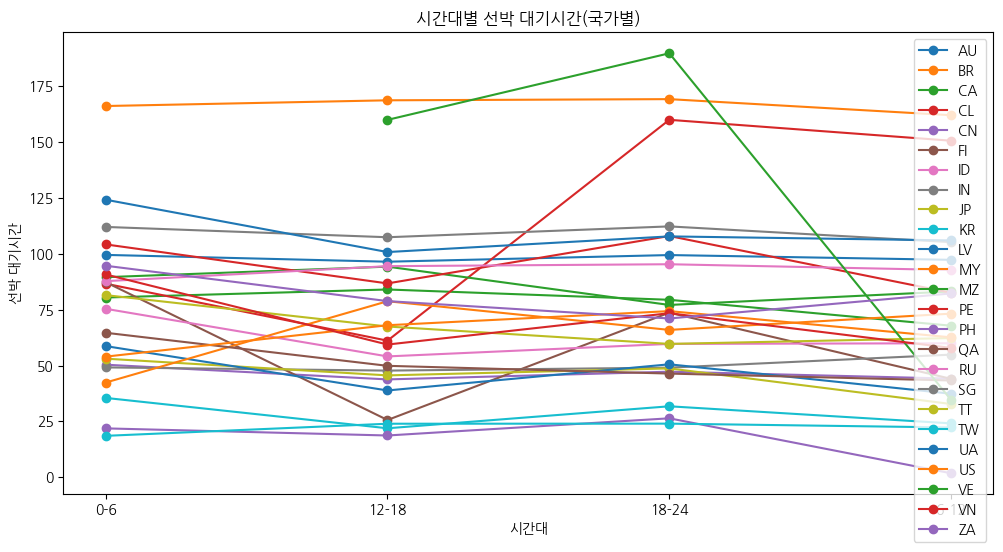

In [873]:
# 시간대별 선박대기시간(+국가별)
# data_grouped = df.groupby(['ARI_PO', 'hour_lt_cat'])['CI_HOUR'].mean()   #항구별
data_grouped = df.groupby(['ARI_CO', 'hour_lt_cat'])['CI_HOUR'].mean()

plt.figure(figsize=(12, 6))
for ari_po, group_data in data_grouped.groupby('ARI_CO'):
    plt.plot(group_data.index.get_level_values('hour_lt_cat'), group_data.values, marker='o', linestyle='-', label=ari_po)

plt.xlabel('시간대'); plt.ylabel('선박 대기시간')
plt.title('시간대별 선박 대기시간(국가별)')
plt.legend(loc='upper right')
plt.show()

In [874]:
# # 국가-현지시간대 칼럼 추가
# df['co_hour_lt'] = df['ARI_CO']+df['hour_lt_cat']
# test['co_hour_lt'] = test['ARI_CO']+test['hour_lt_cat']

# df[['co_hour_lt','ARI_CO','hour_lt_cat']].head()

In [875]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ID                  391939 non-null  object 
 5   BREADTH             391939 non-null  float64
 6   BUILT               391939 non-null  int64  
 7   DEADWEIGHT          391939 non-null  int64  
 8   DEPTH               391939 non-null  float64
 9   DRAUGHT             391939 non-null  float64
 10  GT                  391939 non-null  int64  
 11  LENGTH              391939 non-null  float64
 12  SHIPMANAGER         391939 non-null  object 
 13  FLAG                391939 non-null  object 
 14  U_WIND              391939 non-null  float64
 15  V_WIND              391939 non-nul

### **GT에 따른 대기시간**
- 용적톤수에 따라 대기시간이 달라지지는 않음
- 무거운 선박 -> 대기시간 차이가 큼 -> 데이터 수가 적어서?

- 최대-최소 스케일링을 했더니 완벽한 선형으로 나옴!!! (스캐터플랏)

In [876]:
def grap_hist(col, name, c, bin):   #히스트플랏 그리는 함수(칼럼명, 그래프제목, 색상)
    plt.figure(figsize=(10, 5))
    plt.hist(df[col], bins=bin, color=c, edgecolor='black')

    plt.title(name)
    plt.xlabel(col); plt.show()

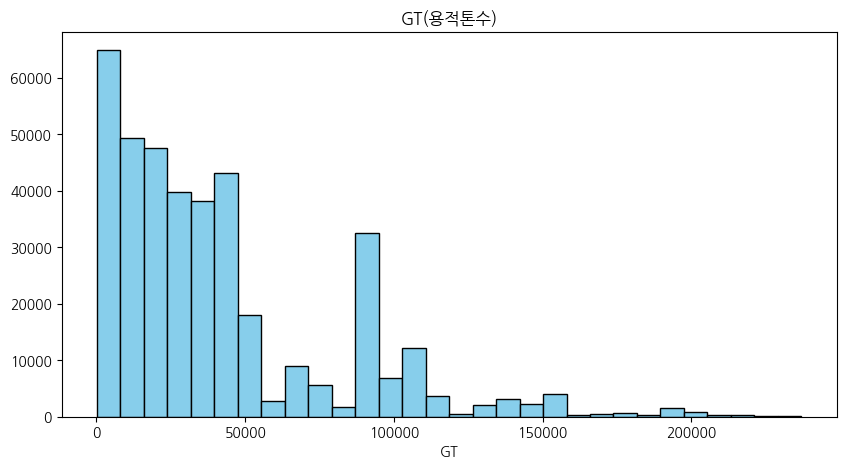

In [877]:
grap_hist('GT','GT(용적톤수)','skyblue', 30)

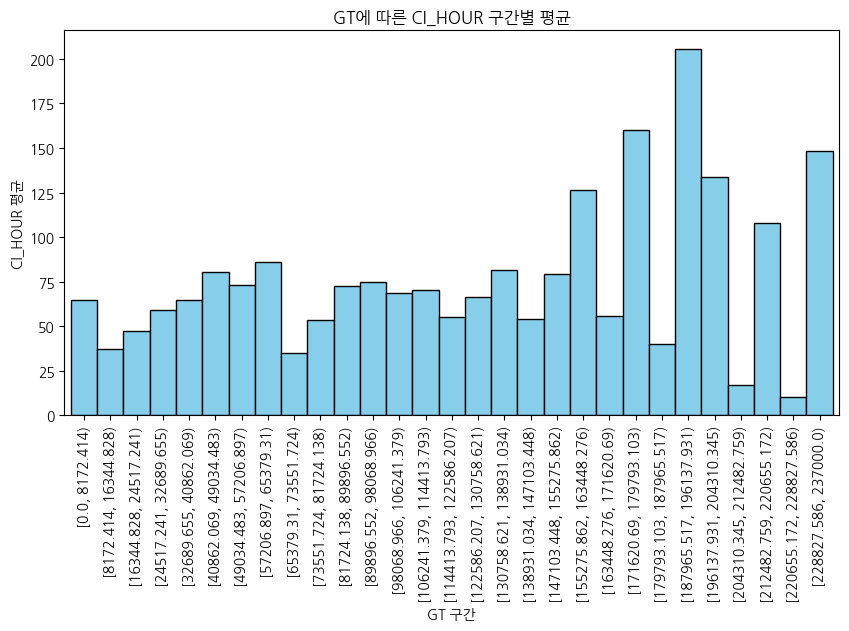

In [878]:
bins = np.linspace(0, max(df.GT), 30)  #구간 나누기
df['GT_BIN'] = pd.cut(df['GT'], bins=bins, right=False)   #GT 구간별로 쪼갠 것
grouped_data = df.groupby('GT_BIN')['CI_HOUR'].mean()   #GT_BIN에 따른 CI_HOUR 평균

plt.figure(figsize=(10, 5))
grouped_data.plot(kind='bar', color='skyblue', edgecolor='black', width=1)
plt.title('GT에 따른 CI_HOUR 구간별 평균')
plt.xlabel('GT 구간'); plt.ylabel('CI_HOUR 평균')
plt.show()

df.drop(columns='GT_BIN', inplace=True)

Text(0, 0.5, '대기시간')

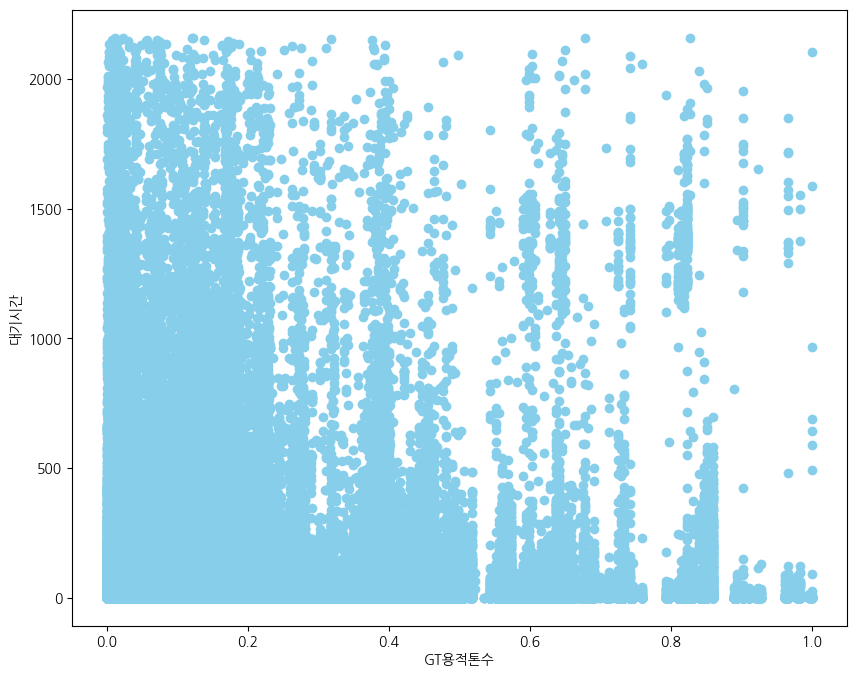

In [879]:
# 최대-최소 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

adf = df[['GT','CI_HOUR']]
adf['GT'] = scaler.fit_transform(adf[['GT']])

plt.figure(figsize=(10,8))
plt.scatter(adf['GT'], adf['CI_HOUR'], c='skyblue')
plt.xlabel('GT용적톤수')
plt.ylabel('대기시간')

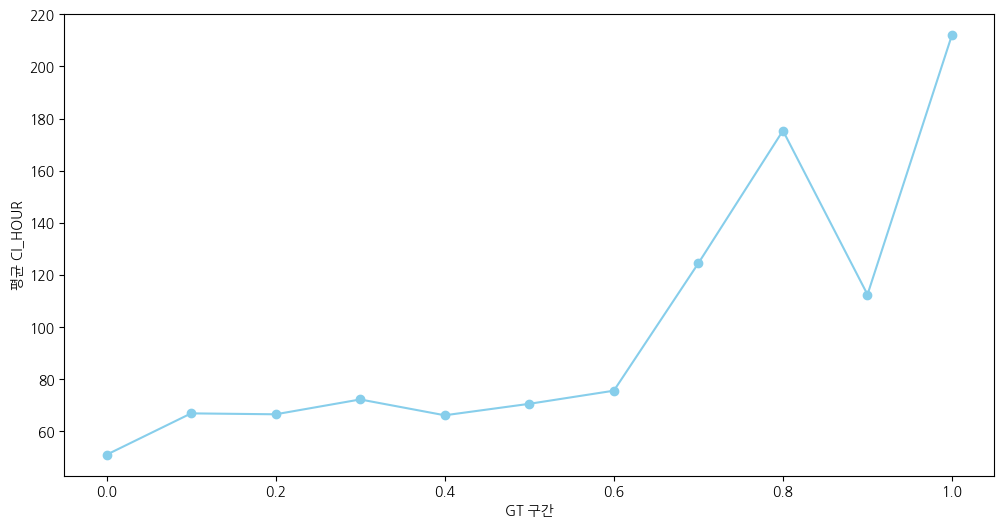

In [880]:
# 용적톤수 10개 구간별 평균 대기시간
adf['GT_group'] = (adf['GT'] // 0.1) * 0.1
grouped = adf.groupby('GT_group')['CI_HOUR'].mean()

plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='skyblue')
plt.xlabel('GT 구간')
plt.ylabel('평균 CI_HOUR')
plt.show()

In [881]:
adf.groupby('GT_group')['CI_HOUR'].count()

GT_group
0.0    161817
0.1    121082
0.2     29551
0.3     39924
0.4     22758
0.5      5646
0.6      6649
0.7      1301
0.8      2624
0.9       553
1.0        34
Name: CI_HOUR, dtype: int64

In [882]:
df['GT'] = scaler.fit_transform(df[['GT']])
test['GT'] = scaler.fit_transform(test[['GT']])

### **DIST(정박지-접안지 사이 거리)에 따른 대기시간**
- 거리가 멀어질 수록 증가하는 그래프
- 거리가 가까우면 대기시간도 짧다x 거리가 멀면 대기시간이 길 확률이 높아짐

In [883]:
# 최대최소 스케일링
adf = df[['DIST','CI_HOUR']]
adf['DIST'] = scaler.fit_transform(adf[['DIST']])

Text(0, 0.5, '대기시간')

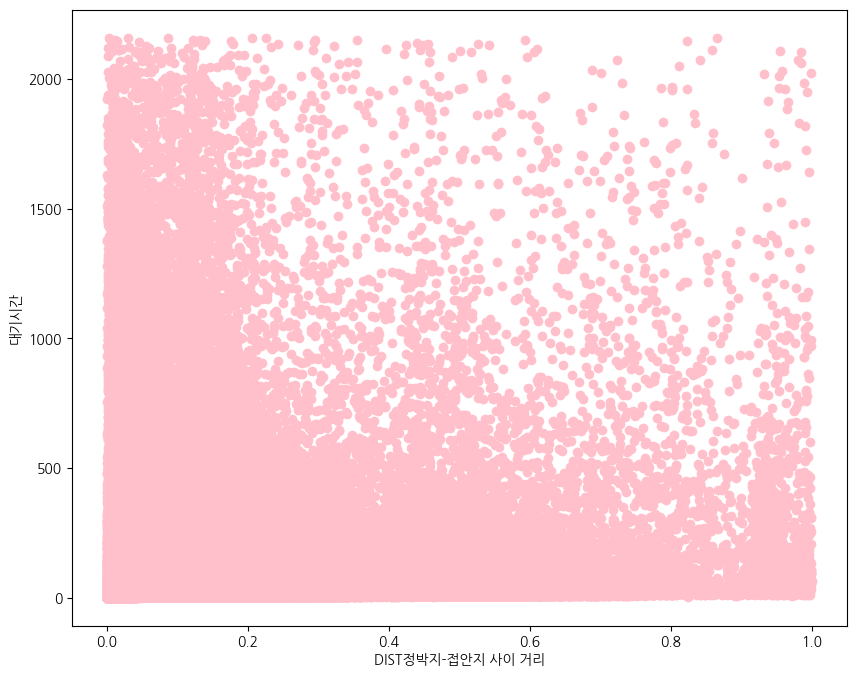

In [884]:
plt.figure(figsize=(10,8))
plt.scatter(adf['DIST'], adf['CI_HOUR'], c='pink')
plt.xlabel('DIST정박지-접안지 사이 거리')
plt.ylabel('대기시간')

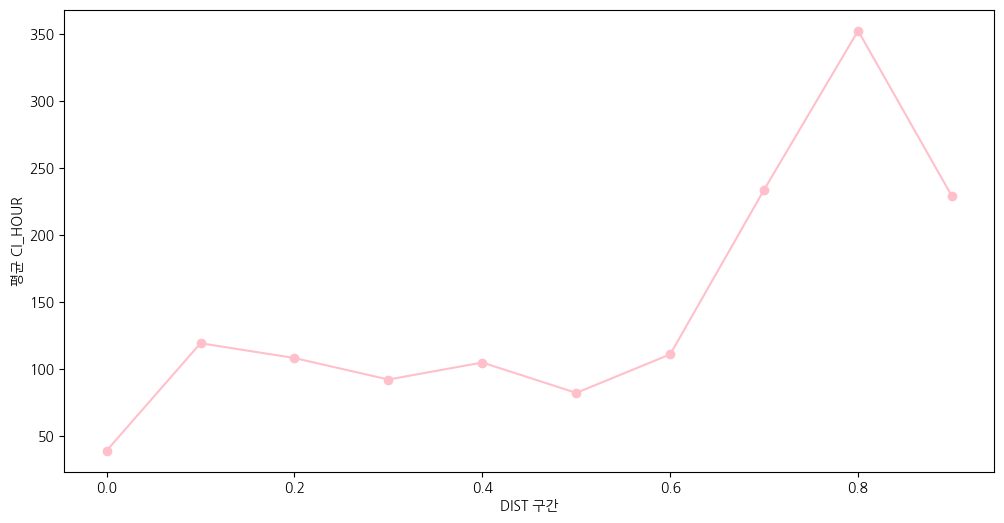

In [885]:
# 정박지-접안지 거리 별 평균 대기시간
adf['DIST_group'] = (adf['DIST'] // 0.1) * 0.1
grouped = adf.groupby('DIST_group')['CI_HOUR'].mean()

plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='pink')
plt.xlabel('DIST 구간')
plt.ylabel('평균 CI_HOUR')
plt.show()

In [886]:
adf.groupby('DIST_group')['CI_HOUR'].count()

DIST_group
0.0    271217
0.1     64090
0.2     20077
0.3     10694
0.4      8882
0.5      9512
0.6      4014
0.7      1281
0.8       566
0.9      1606
Name: CI_HOUR, dtype: int64

In [887]:
df['DIST'] = scaler.fit_transform(df[['DIST']])
test['DIST'] = scaler.fit_transform(test[['DIST']])

### **DEADWEIGHT(재화중량톤수)에 따른 대기시간**
- 선박 재화중량톤수: 선박이 운반할 수 있는 중량(선원, 화물 등 전부 포함)

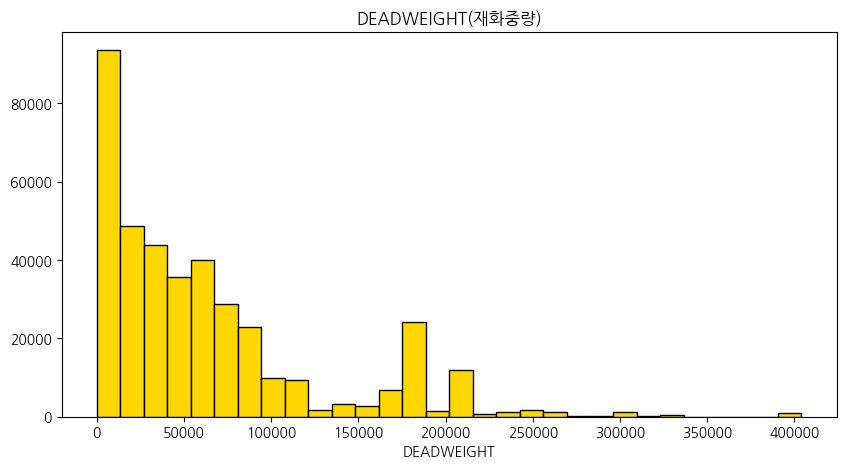

In [888]:
# 분포
grap_hist('DEADWEIGHT','DEADWEIGHT(재화중량)','gold', 30)

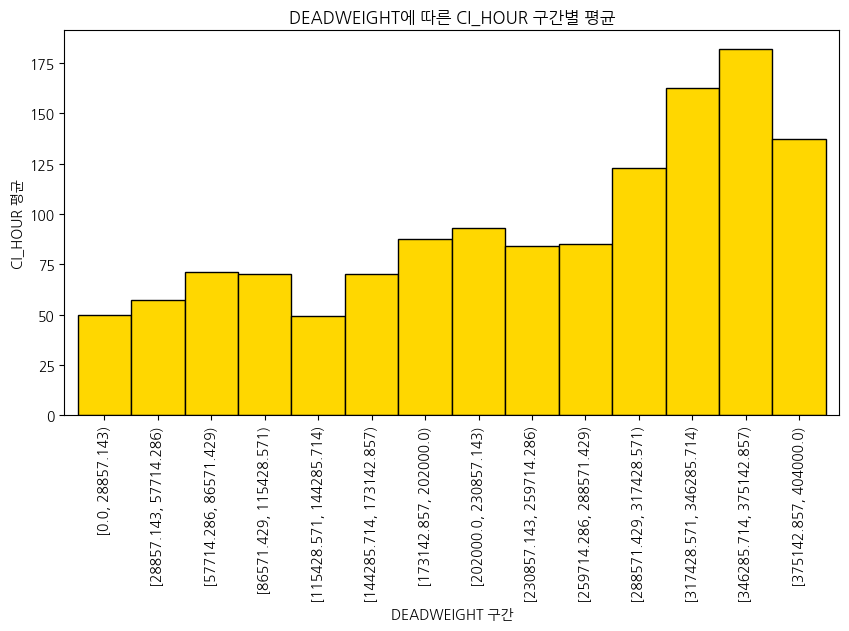

In [889]:
#DEADWEIGHT_BIN에 따른 CI_HOUR 평균
bins = np.linspace(0, max(df.DEADWEIGHT), 15)  #구간 나누기
df['DEADWEIGHT_BIN'] = pd.cut(df['DEADWEIGHT'], bins=bins, right=False)   #DEADWEIGHT 구간별로 쪼갠 것
grouped_data = df.groupby('DEADWEIGHT_BIN')['CI_HOUR'].mean()

plt.figure(figsize=(10, 5))
grouped_data.plot(kind='bar', color='gold', edgecolor='black', width=1)
plt.title('DEADWEIGHT에 따른 CI_HOUR 구간별 평균')
plt.xlabel('DEADWEIGHT 구간'); plt.ylabel('CI_HOUR 평균')
plt.show()

df.drop(columns='DEADWEIGHT_BIN', inplace=True)

Text(0, 0.5, '대기시간')

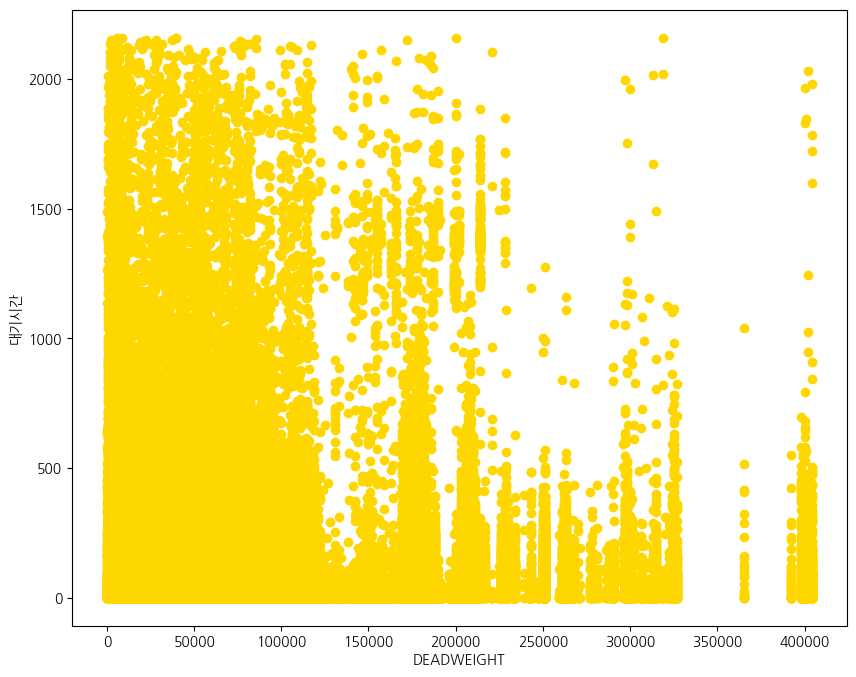

In [890]:
# 스캐터플랏
plt.figure(figsize=(10,8))
plt.scatter(df['DEADWEIGHT'], df['CI_HOUR'], c='gold')
plt.xlabel('DEADWEIGHT')
plt.ylabel('대기시간')

In [891]:
# 최대최소 스케일링
adf = df[['DEADWEIGHT','CI_HOUR']]
adf['DEADWEIGHT'] = scaler.fit_transform(adf[['DEADWEIGHT']])

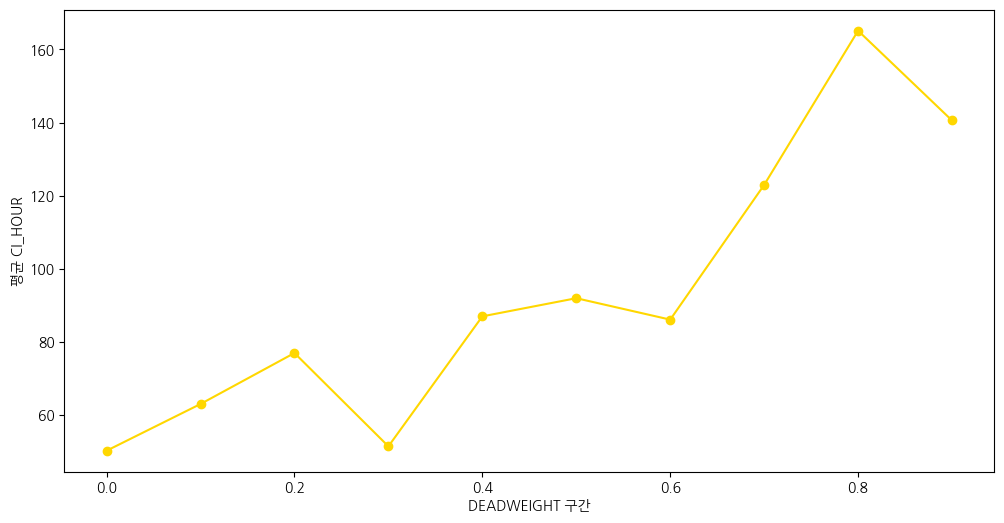

In [892]:
# DEADWEIGHT 별 평균 대기시간
adf['DEADWEIGHT_group'] = (adf['DEADWEIGHT'] // 0.1) * 0.1
grouped = adf.groupby('DEADWEIGHT_group')['CI_HOUR'].mean()

plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='gold')
plt.xlabel('DEADWEIGHT 구간')
plt.ylabel('평균 CI_HOUR')
plt.show()

In [893]:
adf.groupby('DEADWEIGHT_group')['CI_HOUR'].count()

DEADWEIGHT_group
0.0    186076
0.1    104356
0.2     42147
0.3      7540
0.4     32328
0.5     13835
0.6      2931
0.7      1509
0.8       351
0.9       866
Name: CI_HOUR, dtype: int64

In [894]:
df['DEADWEIGHT'] = scaler.fit_transform(df[['DEADWEIGHT']])
test['DEADWEIGHT'] = scaler.fit_transform(test[['DEADWEIGHT']])

### **용적톤수-재화중량톤수**

Text(0, 0.5, 'GT 용적톤수')

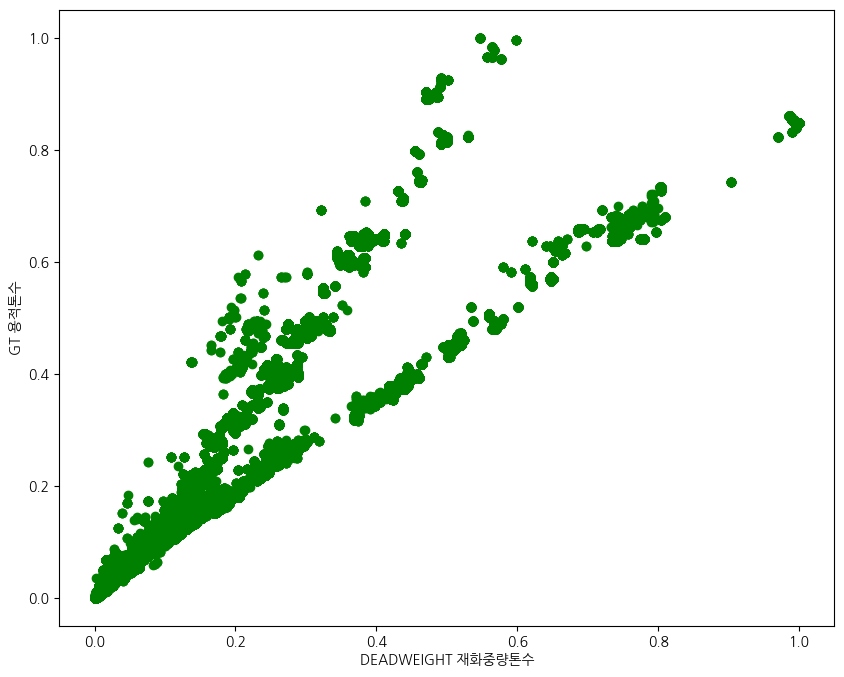

In [895]:
# 용적톤수-재화중량톤수 스캐터플랏
plt.figure(figsize=(10,8))
plt.scatter(df['DEADWEIGHT'], df['GT'], c='green')
plt.xlabel('DEADWEIGHT 재화중량톤수')
plt.ylabel('GT 용적톤수')

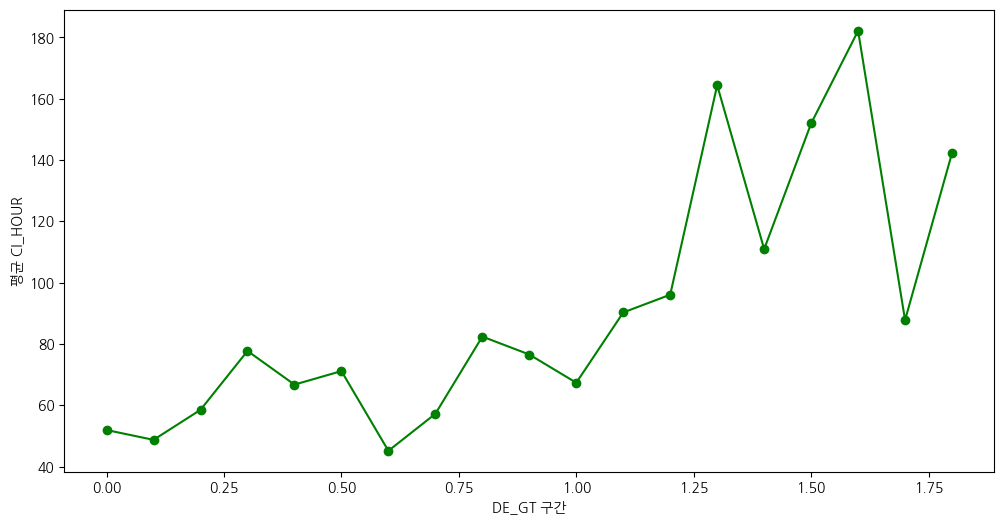

In [896]:
df['DE_GT'] = df['DEADWEIGHT'] + df['GT']

# plt.figure(figsize=(10,8))
# plt.scatter(df['DE_GT'], df['CI_HOUR'], c='green')
# plt.xlabel('DE_GT')
# plt.ylabel('CI_HOUR')

df['DE_GT_group'] = (df['DE_GT'] // 0.1) * 0.1
grouped = df.groupby('DE_GT_group')['CI_HOUR'].mean()
plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='green')
plt.xlabel('DE_GT 구간')
plt.ylabel('평균 CI_HOUR')
plt.show()

df.drop(['DE_GT','DE_GT_group'], axis=1, inplace=True)

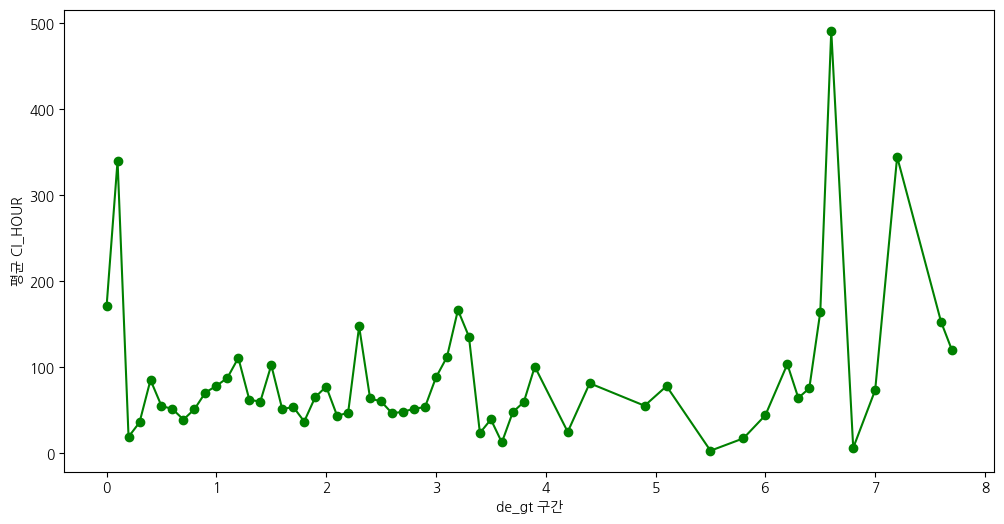

In [897]:
df['de_gt'] = df['DEADWEIGHT'] / df['GT']

df['de_gt_group'] = (df['de_gt'] // 0.1) * 0.1
grouped = df.groupby('de_gt_group')['CI_HOUR'].mean()
plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='green')
plt.xlabel('de_gt 구간')
plt.ylabel('평균 CI_HOUR')
plt.show()

df.drop(['de_gt','de_gt_group'], axis=1, inplace=True)

### **선박정보**

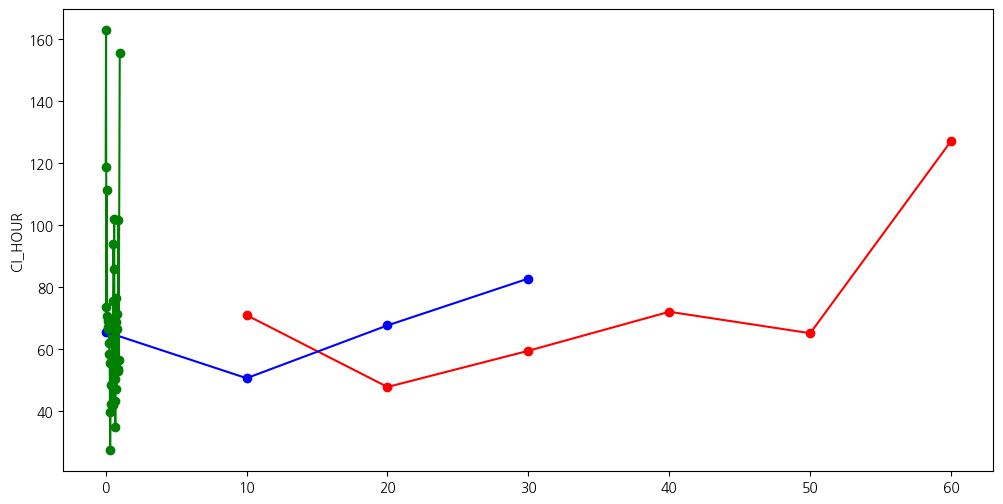

In [898]:
# 선박 길이 -> 별 관계x -> 칼럼 삭제
df['LENGTH'] = scaler.fit_transform(df[['LENGTH']])

grouped1 = df.groupby('BREADTH')['CI_HOUR'].mean()   #선박 폭(빨)
grouped2 = df.groupby('DEPTH')['CI_HOUR'].mean()   #선박 깊이(파)
# grouped4 = df.groupby('LENGTH')['CI_HOUR'].mean()   #선박 길이(초)

plt.figure(figsize=(12, 6))
plt.plot(grouped1.index, grouped1.values, marker='o', linestyle='-', color='red')
plt.plot(grouped2.index, grouped2.values, marker='o', linestyle='-', color='blue')
plt.plot(grouped4.index, grouped4.values, marker='o', linestyle='-', color='green')

plt.ylabel('CI_HOUR')
plt.show()

df.drop('LENGTH', axis=1, inplace=True)
test.drop('LENGTH', axis=1, inplace=True)

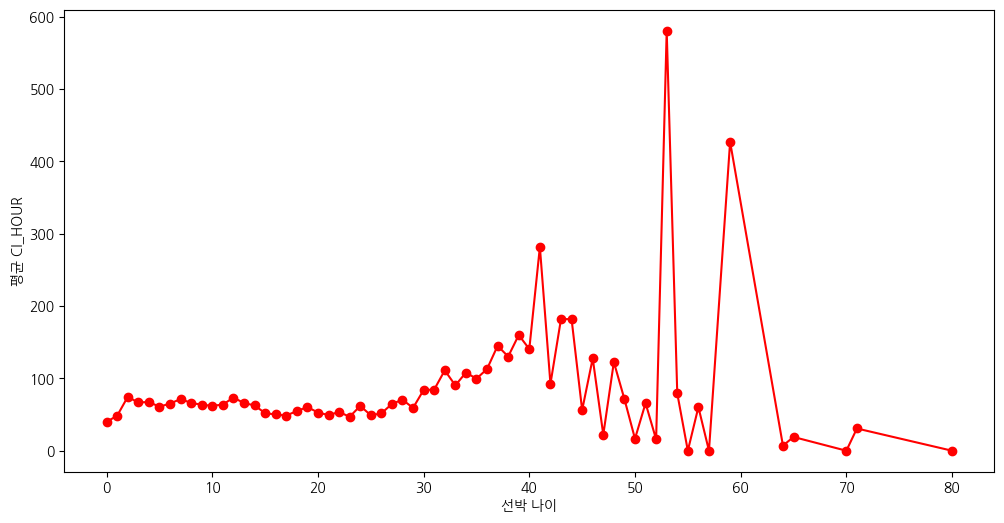

In [899]:
# 선박 나이 -> 관계x -> 칼럼 삭제
grouped = df.groupby('BUILT')['CI_HOUR'].mean()
plt.figure(figsize=(12, 6))
plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color='red')
plt.xlabel('선박 나이')
plt.ylabel('평균 CI_HOUR')
plt.show()

df.drop('BUILT', axis=1, inplace=True)
test.drop('BUILT', axis=1, inplace=True)

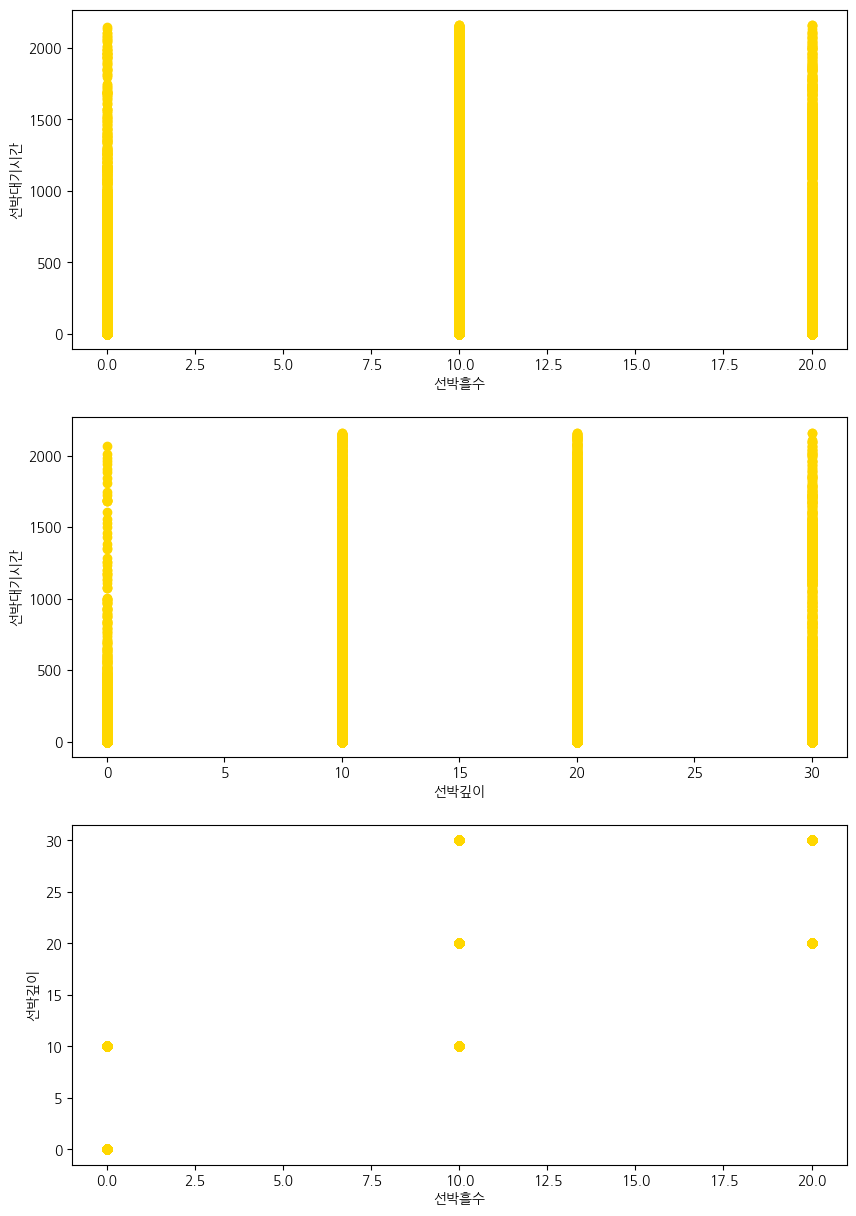

In [900]:
plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
plt.scatter(df['DRAUGHT'], df['CI_HOUR'], c='gold')
plt.xlabel('선박흘수'); plt.ylabel('선박대기시간')

plt.subplot(3, 1, 2) 
plt.scatter(ship_df['DEPTH'], ship_df['CI_HOUR'], c='gold')
plt.xlabel('선박깊이'); plt.ylabel('선박대기시간')

plt.subplot(3, 1, 3) 
plt.scatter(ship_df['DRAUGHT'], ship_df['DEPTH'], c='gold')
plt.xlabel('선박흘수'); plt.ylabel('선박깊이')
plt.show()

In [901]:
df['draught_depth'] = df['DRAUGHT'] + df['DEPTH']
test['draught_depth'] = ship_test['DRAUGHT'] + ship_test['DEPTH']

Text(0, 0.5, '대기시간')

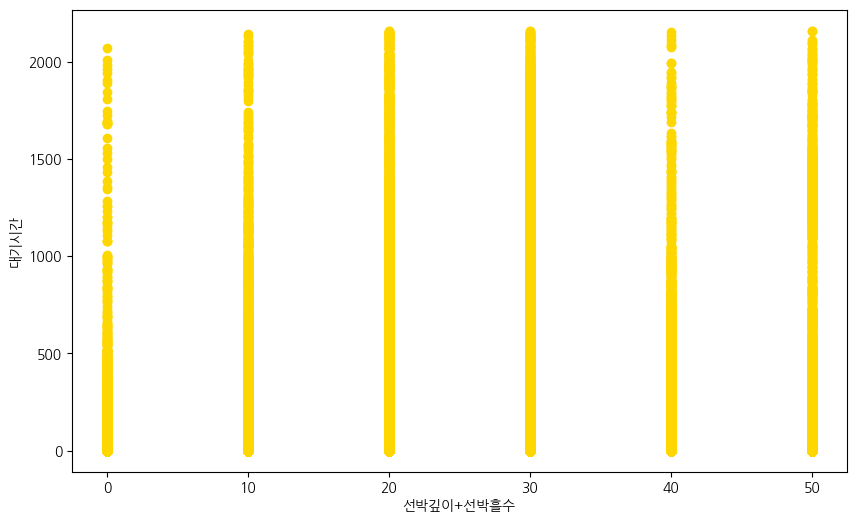

In [902]:
plt.figure(figsize=(10,6))
plt.scatter(df['draught_depth'], df['CI_HOUR'], c='gold')
plt.xlabel('선박깊이+선박흘수')
plt.ylabel('대기시간')

### **날짜(년/월/일)**

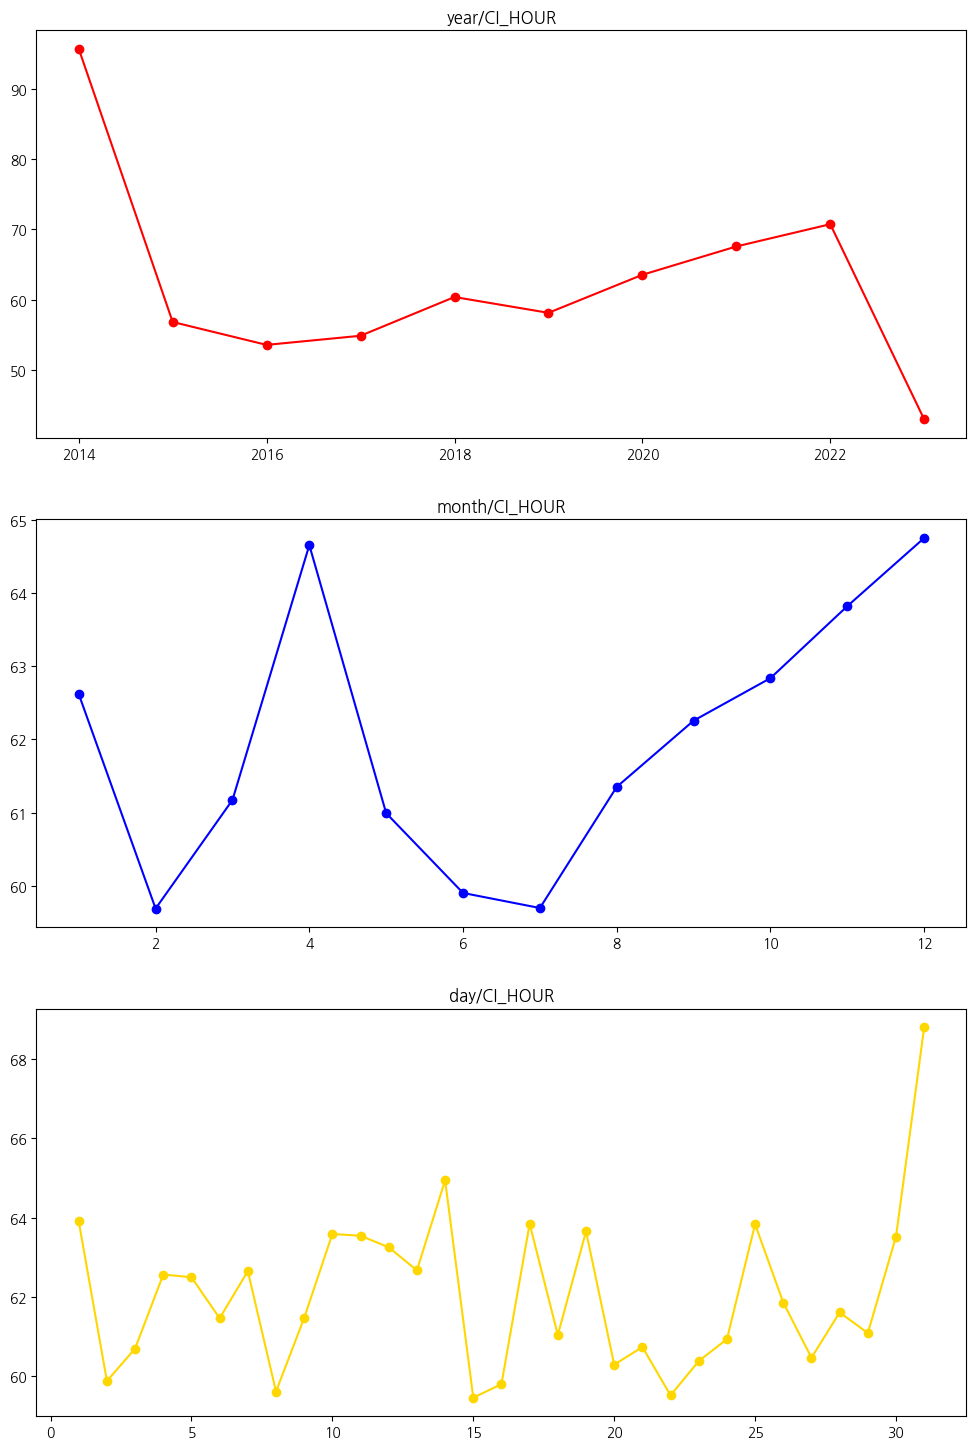

In [903]:
grouped1 = df.groupby('year')['CI_HOUR'].mean()
grouped2 = df.groupby('month')['CI_HOUR'].mean()
grouped3 = df.groupby('day')['CI_HOUR'].mean()

fig, axes = plt.subplots(3, 1, figsize=(12, 18))  # 3개의 서브플롯을 세로로 나란히 배치
axes[0].plot(grouped1.index, grouped1.values, marker='o', linestyle='-', color='red')
axes[1].plot(grouped2.index, grouped2.values, marker='o', linestyle='-', color='blue')
axes[2].plot(grouped3.index, grouped3.values, marker='o', linestyle='-', color='gold')

axes[0].set_title('year/CI_HOUR')
axes[1].set_title('month/CI_HOUR')
axes[2].set_title('day/CI_HOUR')
plt.show()

In [904]:
df[df.year==2014]

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,...,CI_HOUR,year,month,day,hour,minute,weekday,hour_cat,hour_lt_cat,draught_depth
1,IN,UJM2,Bulk,0.000000,X886125,30.0,0.088636,10.0,10.0,0.098586,...,0.000000,2014,9,23,6,59,1,6-12,12-18,20.0
162,SG,GIW5,Bulk,0.000000,V575572,30.0,0.073038,10.0,10.0,0.075364,...,0.000000,2014,10,15,14,56,2,12-18,18-24,20.0
301,AU,WHH4,Bulk,0.121039,J737514,50.0,0.509780,20.0,20.0,0.451129,...,74.961667,2014,9,1,1,8,0,0-6,6-12,40.0
398,AU,AIB7,Bulk,0.245674,D128141,30.0,0.182223,20.0,10.0,0.161495,...,60.745833,2014,10,24,11,16,4,6-12,18-24,30.0
523,AU,WXQ2,Bulk,0.186754,T378247,40.0,0.445407,20.0,20.0,0.398353,...,15.944167,2014,9,2,13,22,1,12-18,18-24,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391668,MZ,PAF4,Bulk,0.107036,V556351,30.0,0.140629,20.0,10.0,0.138273,...,27.267778,2014,12,18,6,47,3,6-12,6-12,30.0
391681,TW,JWI3,Bulk,0.000000,E722451,30.0,0.145085,20.0,10.0,0.139118,...,0.000000,2014,10,7,17,18,1,12-18,0-6,30.0
391704,US,UIR7,Container,0.000000,Y325866,30.0,0.165635,20.0,10.0,0.229892,...,0.000000,2014,10,2,3,11,3,0-6,18-24,30.0
391817,SG,GIW5,Container,0.000000,X725386,50.0,0.286952,30.0,20.0,0.480684,...,0.000000,2014,11,18,7,3,1,6-12,12-18,50.0


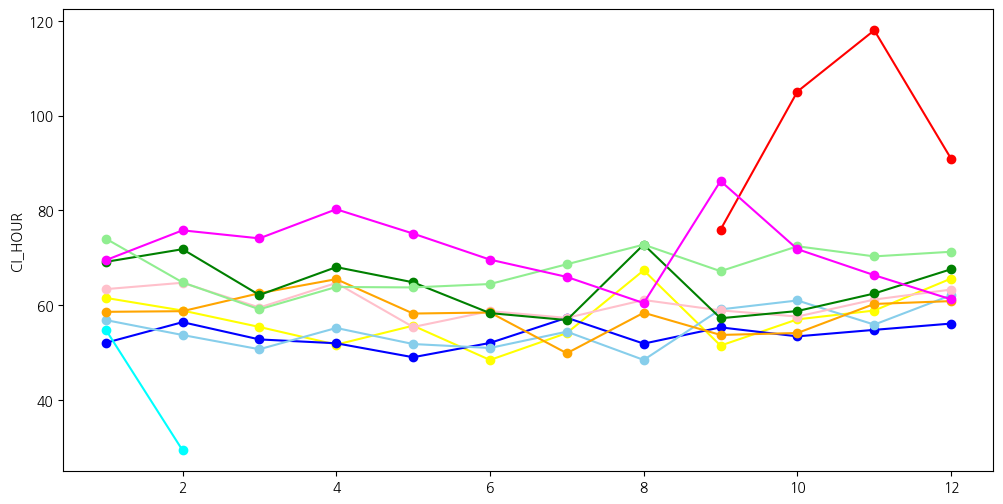

In [905]:
# 년도별 월별 대기시간 -> 2014년, 2023년 잘려 있음 -> 너무 극적인 수치
color = ['red','yellow','blue','skyblue','pink','orange','green','lightgreen','Magenta','Cyan']

plt.figure(figsize=(12, 6))
for i,j in zip(range(2014, 2024, 1), color):
    grouped = df[df.year==i].groupby('month')['CI_HOUR'].mean()
    plt.plot(grouped.index, grouped.values, marker='o', linestyle='-', color=j)

plt.ylabel('CI_HOUR')
plt.show()

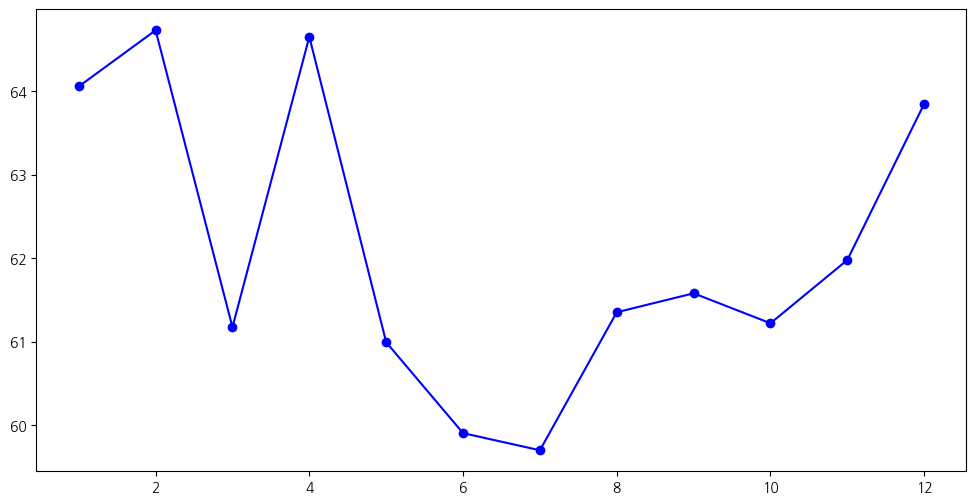

In [906]:
# 2014와 2023를 제외하고 본 추이 -> 그래프가 좀 다름
xdf = df[(df.year!=2014) & (df.year!=2023)]
grouped2 = xdf.groupby('month')['CI_HOUR'].mean()

plt.figure(figsize=(12, 6))
plt.plot(grouped2.index, grouped2.values, marker='o', linestyle='-', color='blue')
plt.show()

In [907]:
## 년도별 월 개수 확인
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(df.groupby(['year','month'])['month'].count())
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')

In [908]:
df['year_month'] = df['year'].astype(str) + '_' + df['month'].astype(str)
test['year_month'] = test['year'].astype(str) + '_' + test['month'].astype(str)

### **바람**

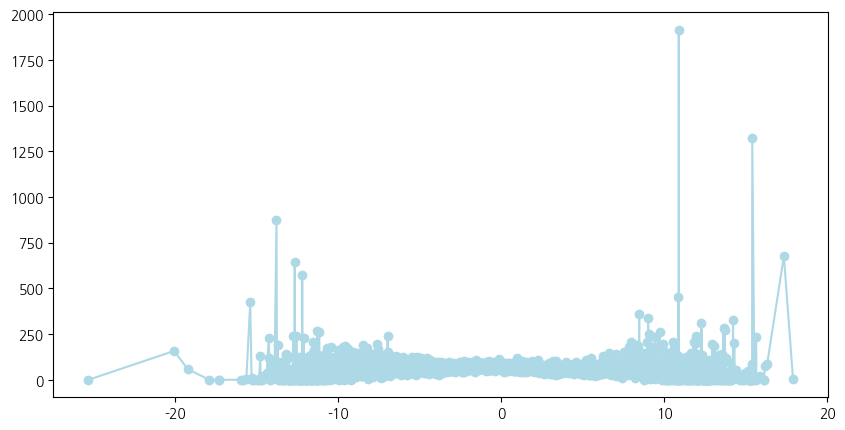

In [909]:
wind2 = ship_df.groupby('U_WIND')['CI_HOUR'].mean()
plt.figure(figsize=(10, 5))
plt.plot(wind2.index, wind2.values, marker='o', linestyle='-', color='lightblue')

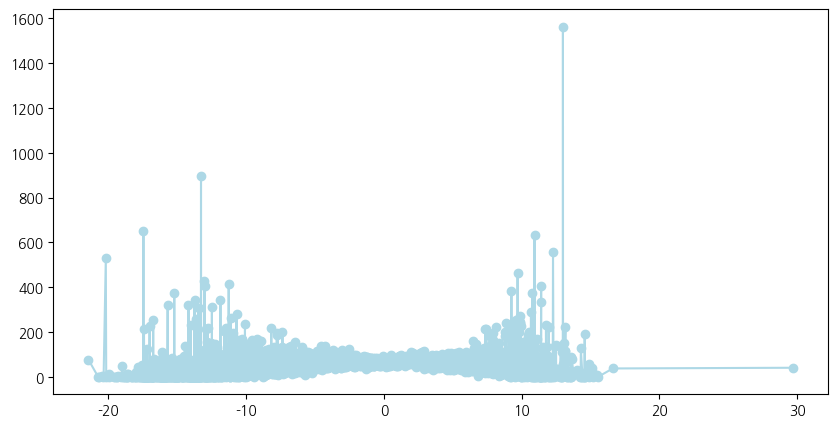

In [910]:
wind2 = ship_df.groupby('V_WIND')['CI_HOUR'].mean()
plt.figure(figsize=(10, 5))
plt.plot(wind2.index, wind2.values, marker='o', linestyle='-', color='lightblue')

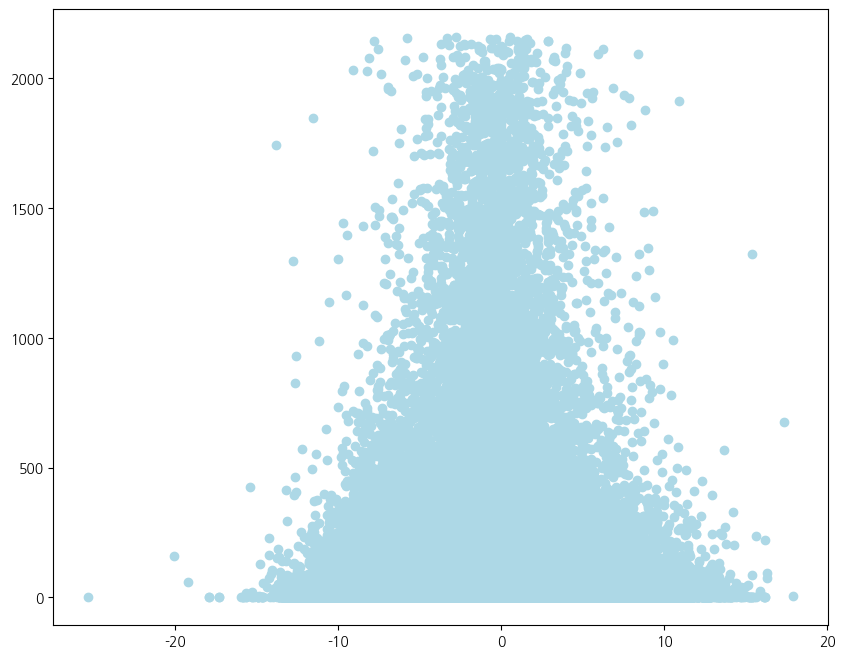

In [911]:
plt.figure(figsize=(10,8))
plt.scatter(ship_df['U_WIND'], ship_df['CI_HOUR'], c='lightblue')

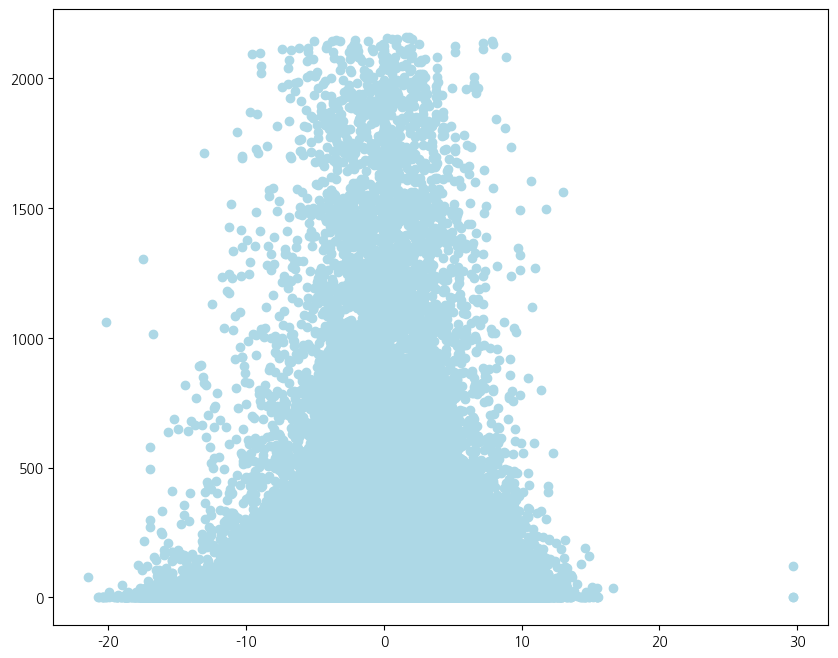

In [912]:
plt.figure(figsize=(10,8))
plt.scatter(ship_df['V_WIND'], ship_df['CI_HOUR'], c='lightblue')

In [913]:
# 풍향 -> 방향만 빼고 풍속은 BN만 사용
def get_wind(uwind, vwind):
    cat1 = ''
    cat2 = ''
    if uwind > 0: cat1='E'
    elif uwind < 0: cat1= 'W'
    else: cat1 = ''
        
    if vwind > 0: cat2='N'
    elif vwind < 0: cat2= 'S'
    else: cat1 = ''
    return cat2+cat1

df['wind'] = df.apply(lambda row: get_wind(row['U_WIND'], row['V_WIND']), axis=1)
test['wind'] = test.apply(lambda row: get_wind(row['U_WIND'], row['V_WIND']), axis=1)

df.drop('U_WIND', axis=1, inplace=True)
df.drop('V_WIND', axis=1, inplace=True)
test.drop('U_WIND', axis=1, inplace=True)
test.drop('V_WIND', axis=1, inplace=True)

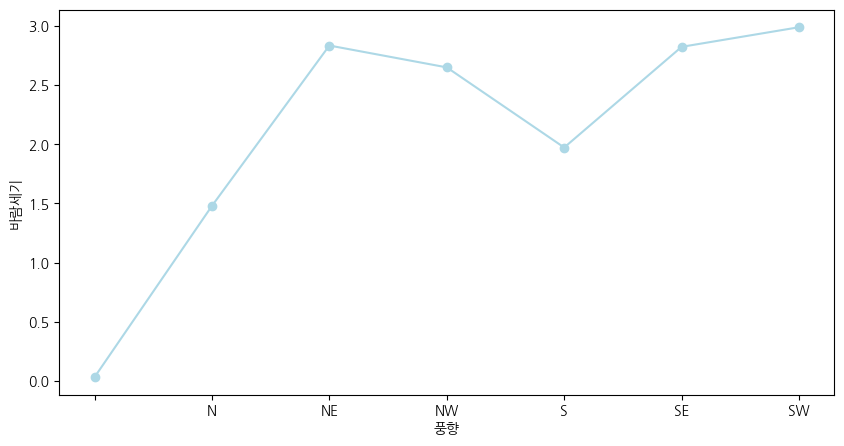

In [914]:
# 풍향별 바람세기
wind2 = df.groupby('wind')['BN'].mean()

plt.figure(figsize=(10, 5))
plt.plot(wind2.index, wind2.values, marker='o', linestyle='-', color='lightblue')
plt.xlabel('풍향'); plt.ylabel('바람세기')
plt.show()

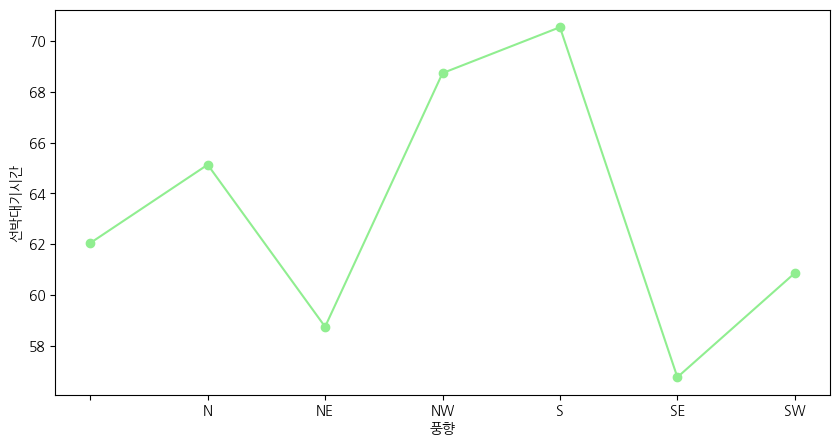

In [915]:
# 풍향별 선박대기시간
wind = df.groupby('wind')['CI_HOUR'].mean()

plt.figure(figsize=(10, 5))
plt.plot(wind.index, wind.values, marker='o', linestyle='-', color='lightgreen')
plt.xlabel('풍향'); plt.ylabel('선박대기시간')
plt.show()

Text(0, 0.5, '선박대기시간')

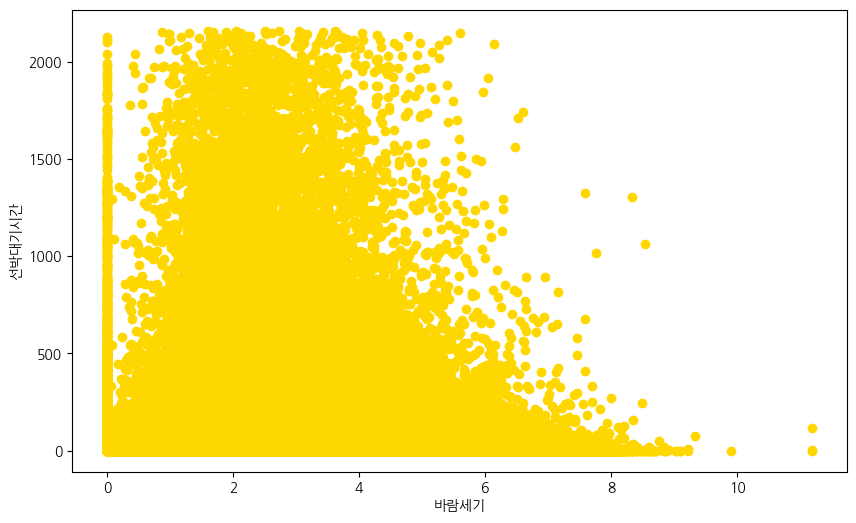

In [916]:
# 바람세기에 따른 선박대기시간 스캐터플랏
plt.figure(figsize=(10,6))
plt.scatter(df['BN'], df['CI_HOUR'], c='gold')
plt.xlabel('바람세기')
plt.ylabel('선박대기시간')

### **기온**

Text(0, 0.5, '선박대기시간')

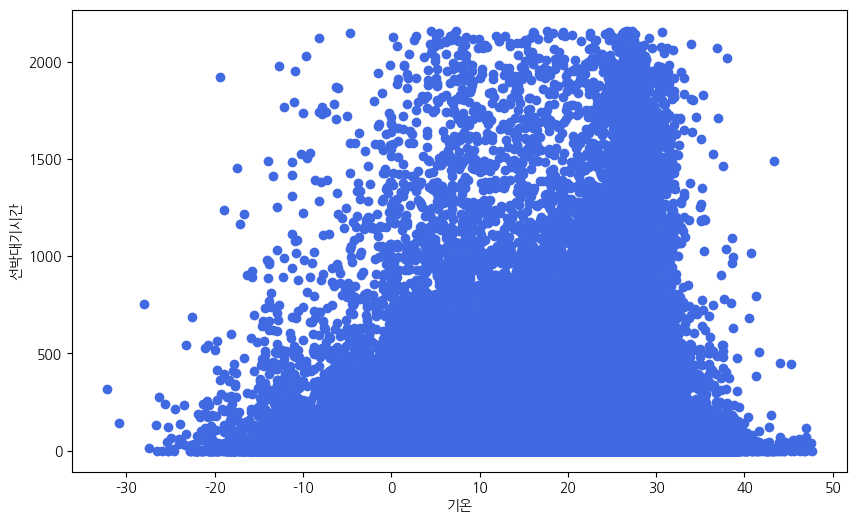

In [917]:
# 기온에 따른 선박대기시간 스캐터플랏
plt.figure(figsize=(10,6))
plt.scatter(df['AIR_TEMPERATURE'], df['CI_HOUR'], c='royalblue')
plt.xlabel('기온')
plt.ylabel('선박대기시간')

### **접안지 폴리곤영역 크기**

Text(0, 0.5, '선박대기시간')

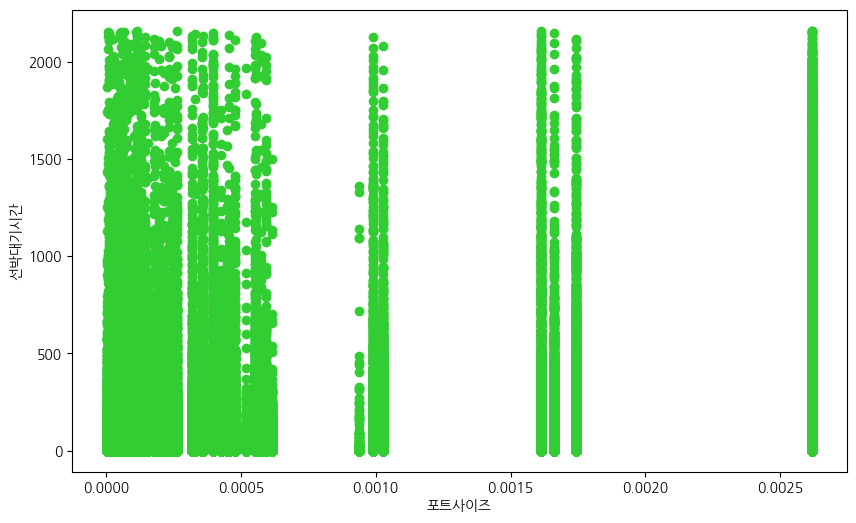

In [918]:
plt.figure(figsize=(10,6))
plt.scatter(df['PORT_SIZE'], df['CI_HOUR'], c='limegreen')
plt.xlabel('포트사이즈')
plt.ylabel('선박대기시간')

In [919]:
# 도착 항구별로 포트사이즈가 정해져있음 -> 항구 칼럼 삭제
# EKP8항구만 포트사이즈 2개
df.PORT_SIZE.unique()

port_size_counts = df[['ARI_PO','PORT_SIZE']].groupby(['ARI_PO','PORT_SIZE']).size().reset_index(name='count')
duplicated_ports = port_size_counts[port_size_counts.duplicated(subset=['ARI_PO'], keep=False)]
duplicated_ports

,ARI_PO,PORT_SIZE,count
13,EKP8,0.000427,8120
14,EKP8,0.001660,19742


Text(0, 0.5, '선박대기시간')

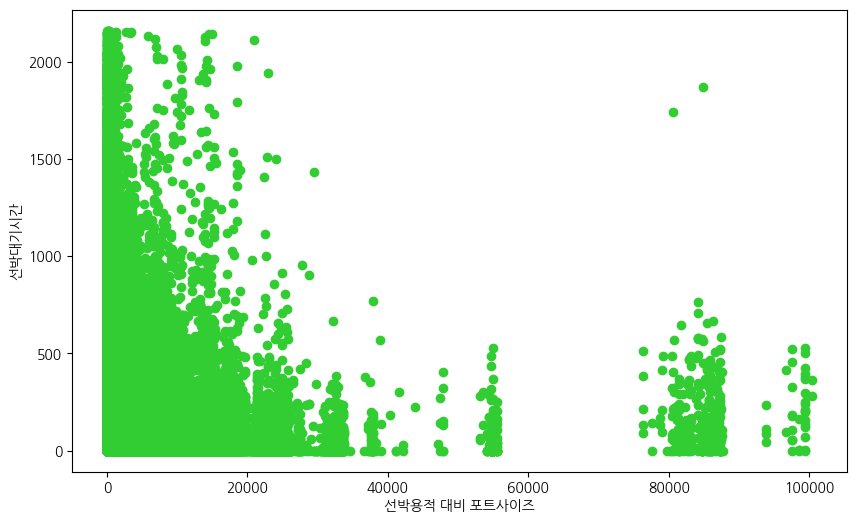

In [920]:
adf = df[['PORT_SIZE','GT','CI_HOUR']]
adf['size'] = df['GT']/df['PORT_SIZE']

plt.figure(figsize=(10,6))
plt.scatter(adf['size'], adf['CI_HOUR'], c='limegreen')
plt.xlabel('선박용적 대비 포트사이즈')
plt.ylabel('선박대기시간')

In [921]:
# 새 칼럼 만들고 포트사이즈 드랍
df['size'] = df['GT'] / df['PORT_SIZE']
test['size'] = test['GT'] / test['PORT_SIZE']

df.drop('PORT_SIZE',axis=1, inplace=True)
test.drop('PORT_SIZE',axis=1, inplace=True)

### **도착항별 대기시간**

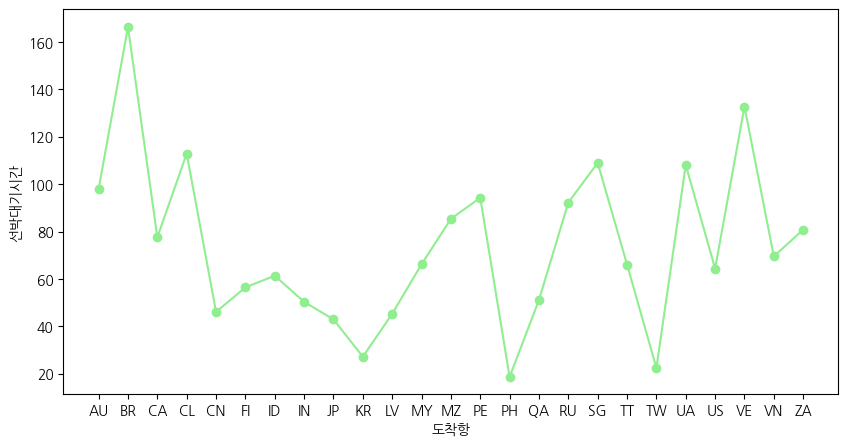

In [922]:
# 도착항별 선박대기시간
wind = df.groupby('ARI_CO')['CI_HOUR'].mean()

plt.figure(figsize=(10, 5))
plt.plot(wind.index, wind.values, marker='o', linestyle='-', color='lightgreen')
plt.xlabel('도착항'); plt.ylabel('선박대기시간')
plt.show()

In [923]:
# 칼럼 삭제
columns = ['ID','ATA_LT','hour','month','minute','FLAG',
           'SHIPMANAGER','ARI_PO','AIR_TEMPERATURE','weekday',
           'SHIP_TYPE_CATEGORY','DRAUGHT','DEPTH']

for idf in [df, test]:
    for col in columns:
        idf.drop(columns=col, axis=1, inplace=True)

In [924]:
df.columns

Index(['ARI_CO', 'DIST', 'BREADTH', 'DEADWEIGHT', 'GT', 'BN', 'CI_HOUR',
       'year', 'day', 'hour_cat', 'hour_lt_cat', 'draught_depth', 'year_month',
       'wind', 'size'],
      dtype='object')

In [925]:
test.columns

Index(['ARI_CO', 'DIST', 'BREADTH', 'DEADWEIGHT', 'GT', 'BN', 'year', 'day',
       'hour_cat', 'hour_lt_cat', 'draught_depth', 'year_month', 'wind',
       'size'],
      dtype='object')

In [926]:
#원핫 인코딩 -> 안됨ㅜㅜ 다 레이블인코딩으로 변경
# train_df = pd.get_dummies(df, columns=['ARI_CO'])
# train_df = pd.get_dummies(train_df, columns=['wind'])

train_df = df.copy()
train_df['ARI_CO'] = LabelEncoder().fit_transform(train_df['ARI_CO'])
train_df['wind'] = LabelEncoder().fit_transform(train_df['wind'])

#레이블 인코딩
train_df['year_month'] = LabelEncoder().fit_transform(train_df['year_month'])
train_df['hour_cat'] = train_df['hour_cat'].replace({'0-6': 0, '6-12': 1, '12-18': 2, '18-24': 3})
train_df['hour_lt_cat'] = train_df['hour_lt_cat'].replace({'0-6': 0, '6-12': 1, '12-18': 2, '18-24': 3})

In [927]:
# 테스트셋도 똑같이 인코딩
test_df = test.copy()
test_df['ARI_CO'] = LabelEncoder().fit_transform(test_df['ARI_CO'])
test_df['wind'] = LabelEncoder().fit_transform(test_df['wind'])

test_df['year_month'] = LabelEncoder().fit_transform(test_df['year_month'])
test_df['hour_cat'] = test_df['hour_cat'].replace({'0-6': 0, '6-12': 1, '12-18': 2, '18-24': 3})
test_df['hour_lt_cat'] = test_df['hour_lt_cat'].replace({'0-6': 0, '6-12': 1, '12-18': 2, '18-24': 3})

In [928]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ARI_CO         391939 non-null  int32  
 1   DIST           391939 non-null  float64
 2   BREADTH        391939 non-null  float64
 3   DEADWEIGHT     391939 non-null  float64
 4   GT             391939 non-null  float64
 5   BN             391939 non-null  float64
 6   CI_HOUR        391939 non-null  float64
 7   year           391939 non-null  int64  
 8   day            391939 non-null  int64  
 9   hour_cat       391939 non-null  int64  
 10  hour_lt_cat    391939 non-null  int64  
 11  draught_depth  391939 non-null  float64
 12  year_month     391939 non-null  int32  
 13  wind           391939 non-null  int32  
 14  size           391939 non-null  float64
dtypes: float64(8), int32(3), int64(4)
memory usage: 40.4 MB


In [929]:
train_df

,ARI_CO,DIST,BREADTH,DEADWEIGHT,GT,BN,CI_HOUR,year,day,hour_cat,hour_lt_cat,draught_depth,year_month,wind,size
0,17,0.154420,30.0,0.059916,0.069875,2.442856,3.450000,2018,17,3,0,20.0,43,6,26.716763
1,7,0.000000,30.0,0.088636,0.098586,3.045980,0.000000,2014,23,1,2,20.0,3,2,455.114800
2,4,0.000000,50.0,0.361228,0.590458,3.191540,0.000000,2015,3,3,1,50.0,8,6,365.797176
3,8,0.000000,20.0,0.016861,0.022166,2.629350,0.000000,2020,17,0,2,20.0,64,6,62.243211
4,17,0.135201,50.0,0.286952,0.407220,2.495953,253.554444,2020,26,1,2,30.0,64,6,155.699804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,8,0.000000,20.0,0.016638,0.019717,1.853619,0.000000,2017,6,0,2,20.0,36,2,35.736772
391935,17,0.029426,10.0,0.007576,0.006122,1.253491,144.061389,2019,16,0,1,20.0,53,3,2.340744
391936,21,0.353335,30.0,0.149047,0.146295,4.766257,41.482222,2021,23,3,3,30.0,81,3,943.553397
391937,19,0.047245,30.0,0.058678,0.070720,3.107321,7.485278,2015,8,1,2,20.0,4,6,71.459543


In [930]:
import os
os.chdir('D:/현대공모전/')

In [931]:
train_df.to_csv('train_df.csv', index=False, encoding='euc-kr')
test_df.to_csv('test_df.csv', index=False, encoding='euc-kr')

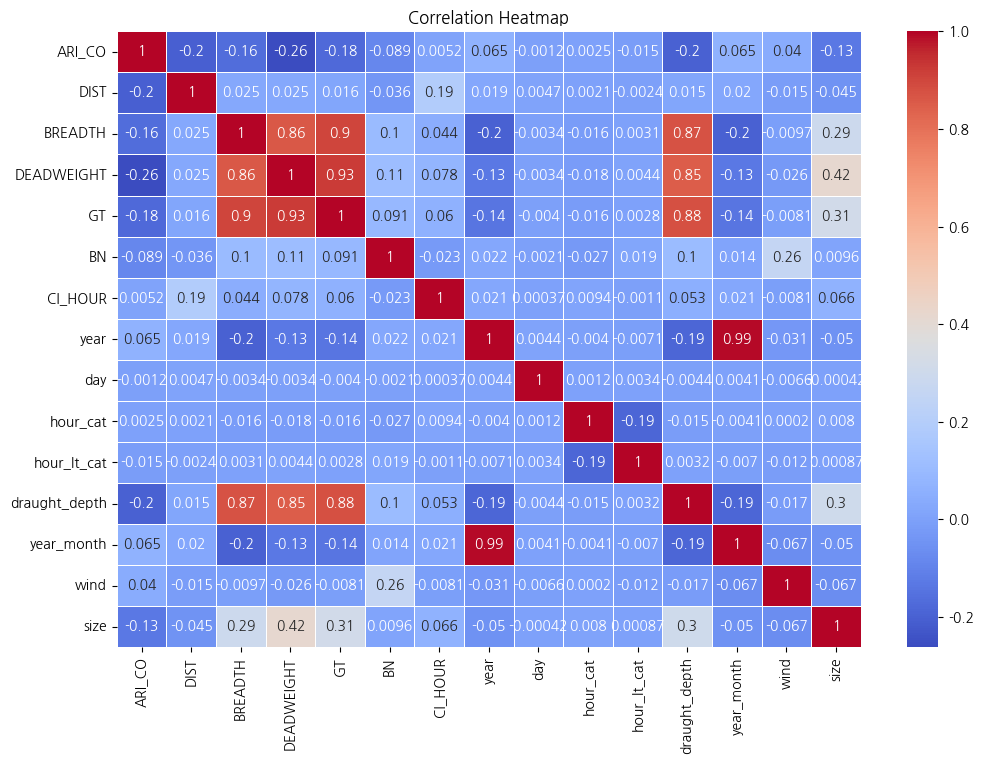

In [932]:
import seaborn as sns
correlation_matrix = train_df.corr()

# 상관 행렬 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [933]:
train_df = pd.read_csv(r'D:\현대공모전\train_df.csv')
test_df = pd.read_csv(r'D:\현대공모전\test_df.csv')

In [938]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

In [ ]:
X_train = train_df.drop(columns='CI_HOUR')
y_train = train_df['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [837]:
## 중요도 낮은 칼럼 제거
# threshold = 85 # Your Threshold
# low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

# X_train_reduced = X_train.drop(columns=low_importance_features)
# X_test_reduced = test.drop(columns=low_importance_features)

### **LGBM**

In [841]:
# LGBM
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정 -> 10으로 변경
num = 10
kf = KFold(n_splits=num, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train), total=num, desc="Processing folds"):
    X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(test_df)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|                                                                         | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1474
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 62.061014


Processing folds:  10%|██████▌                                                          | 1/10 [00:02<00:20,  2.25s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1474
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 62.013230


Processing folds:  20%|█████████████                                                    | 2/10 [00:04<00:18,  2.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1474
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 62.036377


Processing folds:  30%|███████████████████▌                                             | 3/10 [00:06<00:15,  2.22s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 61.734125


Processing folds:  40%|██████████████████████████                                       | 4/10 [00:09<00:13,  2.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 61.956699


Processing folds:  50%|████████████████████████████████▌                                | 5/10 [00:11<00:11,  2.24s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1474
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 61.758545


Processing folds:  60%|███████████████████████████████████████                          | 6/10 [00:13<00:09,  2.27s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 62.160742


Processing folds:  70%|█████████████████████████████████████████████▌                   | 7/10 [00:15<00:06,  2.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 61.737432


Processing folds:  80%|████████████████████████████████████████████████████             | 8/10 [00:18<00:04,  2.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 352745, number of used features: 14
[LightGBM] [Info] Start training from score 61.923684


Processing folds:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [00:20<00:02,  2.28s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1473
[LightGBM] [Info] Number of data points in the train set: 352746, number of used features: 14
[LightGBM] [Info] Start training from score 62.026498


Processing folds: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.27s/it]

Validation : MAE scores for each fold: [56.97682421595938, 57.14680131154248, 57.26388358689112, 59.55929483881821, 57.90225404405278, 58.46139170633357, 56.29688590480937, 58.82938798019093, 57.43323008192711, 57.34845856302571]
Validation : MAE: 57.72184122335507


In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions   #최종 예측값
submit.to_csv('./baseline_submit.csv', index=False)

### **랜덤포레스트**

In [941]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 57.0031471279695


In [945]:
y_pred = rf_model.predict(test_df)
y_pred

array([213.43011944,  56.18284444,  47.32960278, ...,  57.78204167,
         0.        ,  85.69092778])

In [946]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = y_pred   #최종 예측값
submit.to_csv('./baseline_submit.csv', index=False)

### **랜덤포레스트: 그리드서치**

In [ ]:
# 랜덤포레스트: 그리드서치
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 모델 및 하이퍼파라미터 출력
print("Best estimator:", grid_search.best_estimator_)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_estimator = grid_search.best_params_['n_estimators']
best_depth = grid_search.best_params_['max_depth']
best_split = grid_search.best_params_['min_samples_split']
best_leaf = grid_search.best_params_['min_samples_leaf']

In [ ]:
# 베스트 하이퍼파라미터로 돌린 랜덤포레스트
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=best_estimator, 
                            max_depth=best_depth,
                            min_samples_split=best_split,
                            min_samples_leaf=best_leaf,
                            random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

test_pred = rf_model.predict(test_df)
test_pred

In [ ]:
submit = pd.read_csv('./sample_submission2.csv')
submit['CI_HOUR'] = test_pred   #최종 예측값
submit.to_csv('./baseline_submit2.csv', index=False)